# Zadanie 1
## ppkt. 1 / 2

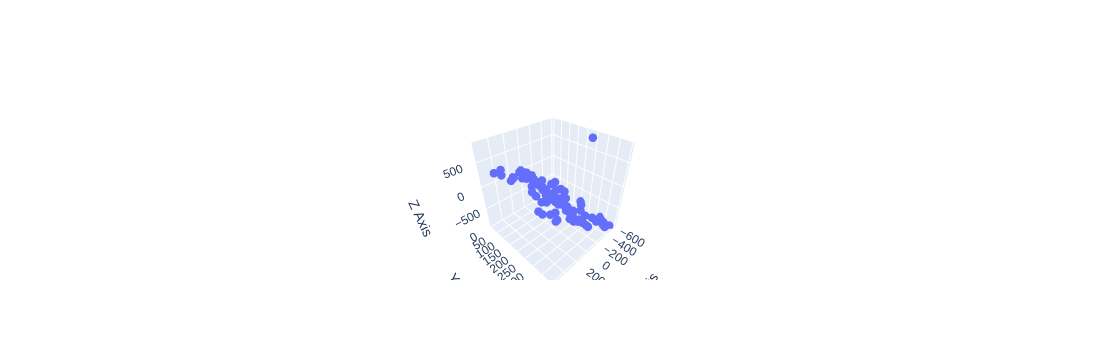

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as plotly

data1 = pd.read_csv("./data1.csv")
x = data1['x1']
y = data1['x2']
z = data1['y']
# print(data1.head())

fig = plotly.Figure(data=[plotly.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=5
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

fig.show()

Widzimy, że poza jednym odstającym punktem jest OK.

In [2]:
from sklearn.neighbors import KNeighborsRegressor

def preprocess_data(X_train, y_train, threshold=3.0, n=5):
    X = pd.DataFrame(X_train).copy()
    y = pd.Series(y_train).copy()
    
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    knn = KNeighborsRegressor(n_neighbors=n)
    #dla kazdego P liczymy srednia y dla 5 sasiadow
    knn.fit(X, y)

    y_pred = knn.predict(X)
    # print(y_pred)

    #roznica faktycznego y i przewidywanego
    diff = y - y_pred
    diff_normalized = (diff - diff.mean()) / diff.std()
    
    # Keep points within threshold
    mask = np.abs(diff_normalized) <= threshold
    X_clean = X[mask].reset_index(drop=True)
    y_clean = y[mask].reset_index(drop=True)

    removed_points = X[~mask].copy()
    removed_points['y'] = y[~mask]
    print("Removed points:")
    print(removed_points)
    
    return X_clean, y_clean

In [3]:
from sklearn.linear_model import LinearRegression
X = data1[['x1', 'x2']]
Y = data1['y']

model = LinearRegression()
model.fit(X, Y)

x_range = np.linspace(X['x1'].min(), X['x1'].max(), 30)
y_range = np.linspace(X['x2'].min(), X['x2'].max(), 30)
x_surf, y_surf = np.meshgrid(x_range, y_range)

z_surf = model.intercept_ + model.coef_[0]*x_surf + model.coef_[1]*y_surf

fig = plotly.Figure()

fig.add_trace(plotly.Scatter3d(
    x=X['x1'],
    y=X['x2'],
    z=Y,
    mode='markers',
    marker=dict(size=5, opacity=0.8)
))

fig.add_trace(plotly.Surface(
    x=x_surf,
    y=y_surf,
    z=z_surf,
    opacity=0.6
))

fig.update_layout(
    title='Unprocessed data',
    scene=dict(
        xaxis_title='x1',
        yaxis_title='x2',
        zaxis_title='y'
    )
)

fig.show()

In [4]:
X = data1[['x1','x2']]
Y = data1['y']
X_c, y_c = preprocess_data(X, Y)

model = LinearRegression()
model.fit(X_c, y_c)
y_pred = model.predict(X)

x_range = np.linspace(X_c['x1'].min(), X_c['x1'].max(), 30)
y_range = np.linspace(X_c['x2'].min(), X_c['x2'].max(), 30)
x_surf, y_surf = np.meshgrid(x_range, y_range)
z_surf = model.intercept_ + model.coef_[0]*x_surf + model.coef_[1]*y_surf

# Plane on preprocessed data
fig = plotly.Figure(data=[plotly.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=5
    )
)])

fig.update_layout(
    title="Processed data",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# Regression plane
fig.add_trace(plotly.Surface(
    x=x_surf,
    y=y_surf,
    z=z_surf,
    opacity=0.5
))

Removed points:
            x1          x2      y
50 -501.847589  254.564165  805.0


# Zadanie 2
## ppkt.1
chcemy miec jak najwiecej danych na uczenie a z drugiej strony jesli model mialby dzialac zle to nie powinien potrzebowac duzo testow aby wyszlo ze cos jest nie tak.
Proponuje podzial 70/30 (dane/test).
Gdy chcemy wytrenowac kilka modeli to powinnismy uzywac tego samego podzialu danych aby nauka byla 'fair'.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_prep, y_train_prep = preprocess_data(X_train, y_train)

# X_test_prep, y_test_prep = preprocess_data(X_test, y_test)

Removed points:
           x1         x2          y
64 -521.40697  43.156571  43.156571


## ppkt. 2
Jako model baselinowy mozemy po prostu zwracac srednia wartosc y 5 najblizszych sasiadow w danych treningowych (jak w preprocessingu)

## ppkt. 3 / 4

In [6]:
from sklearn.metrics import mean_squared_error

baseline_raw = KNeighborsRegressor(5)
baseline_raw.fit(X_train, y_train)
br_predict = baseline_raw.predict(X_test)
# print(f"MSE for baseline model on raw data is: {mean_squared_error(y_test, br_predict)}")

baseline_prep = KNeighborsRegressor(5)
baseline_prep.fit(X_train_prep, y_train_prep)
bp_predict = baseline_prep.predict(X_test)
# print(f"MSE for baseline model on preprocessed data is: {mean_squared_error(y_test, bp_predict)}")

lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
lrr_predict = lr_raw.predict(X_test)
# print(f"MSE for linear regression model on raw data is: {mean_squared_error(y_test, lrr_predict)}")

lr_prep = LinearRegression()
lr_prep.fit(X_train_prep, y_train_prep)
lrp_predict = lr_prep.predict(X_test)
# print(f"MSE for linear regression model on preprocessed data is: {mean_squared_error(y_test, lrp_predict)}")

results = {
    "Model": ["KNN Baseline", "KNN Baseline", "Linear Regression", "Linear Regression"],
    "Data": ["Raw", "Preprocessed", "Raw", "Preprocessed"],
    "MSE": [
        mean_squared_error(y_test, baseline_raw.predict(X_test)),
        mean_squared_error(y_test, baseline_prep.predict(X_test)),
        mean_squared_error(y_test, lr_raw.predict(X_test)),
        mean_squared_error(y_test, lr_prep.predict(X_test))
    ]
}

mse_table = pd.DataFrame({
    'baseline': [mean_squared_error(y_test, baseline_raw.predict(X_test)),
                 mean_squared_error(y_test, baseline_prep.predict(X_test))],
    'linear regression': [mean_squared_error(y_test, lr_raw.predict(X_test)),
                          mean_squared_error(y_test, lr_prep.predict(X_test))]
}, index=['Raw', 'Preprocessed'])

print(mse_table)

                 baseline  linear regression
Raw           1264.546854       1.019945e-27
Preprocessed  1264.195602       8.550200e-28


## ppkt. 5  (na pracowni)

# Zadanie 1
## ppkt. 1
Preprocessing zrobimy taki sam jak poprzednio uzywajac KNN.

In [7]:
data = pd.read_csv("./advertising.csv")

# print(data.head())

# fig = plotly.Figure(data=[plotly.Scatter3d(
#     x=data['TV'], y=data['Radio'], z=data['Newspaper'],
#     mode='markers',
#     marker=dict(
#         size=data['Sales']
#     )
# )])

# fig.update_layout(
#     scene=dict(
#         xaxis_title='TV',
#         yaxis_title='Radio',
#         zaxis_title='Newspaper'
#     )
# )

# fig.show()

# print(len(data['TV']))

# arbitralny threshold ktory nie wywala zbyt wielu punktów
X_prep, y_prep = preprocess_data(data[['TV', 'Radio', 'Newspaper']], data['Sales'], threshold=2)

Removed points:
        TV  Radio  Newspaper     y
10    66.1    5.8       24.2  12.6
36   266.9   43.8        5.0  25.4
55   198.9   49.4       60.0  23.7
113  209.6   20.6       10.7  20.9
128  220.3   49.0        3.2  24.7
130    0.7   39.6        8.7   1.6
137  273.7   28.9       59.7  20.8
175  276.9   48.9       41.8  27.0
197  177.0    9.3        6.4  14.8


## ppkt. 2

In [8]:
# model uczony na danych bez skalowania
lr_raw = LinearRegression()
X, Y = data[['TV', 'Radio', 'Newspaper']], data['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
lr_raw.fit(X_train, y_train)

mse_raw = mean_squared_error(y_test, lr_raw.predict(X_test))
print(mse_raw)
print(lr_raw.coef_)

2.182657512770059
[ 0.05536368  0.10336829 -0.00538486]


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# model uczony na znormalizowanych danych
lr_scaled_data = LinearRegression()
X_train_scaled = scaler.fit_transform(X_train)
lr_scaled_data.fit(X_train_scaled, y_train)

# print(X_train.head(10))
# print(X_train_scaled)

# dane do testu tez OCZYWISCIE skalujemy
X_test_scaled = scaler.transform(X_test)

mse_scaled = mean_squared_error(y_test, lr_scaled_data.predict(X_test_scaled))
print(mse_scaled)
print(lr_scaled_data.coef_)

2.1826575127700565
[ 4.91335379  1.52860815 -0.1229258 ]


## ppkt. 3
Obserwacje:
* MSE minimalnie gorzej dla skalowanych danych. Blad nauczenia scalera? Błędy numeryczne?
* inne wagi, tu liczby a tu ich odchylenia do pomnozenia

## ppkt. 4 (na pracowani)

# Zadanie 4
## ppkt. 1

In [10]:
data = pd.read_csv("./data4.csv")

# print(data.head())

print(data.shape)
print(data.info())
print(data.describe())

(100, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      100 non-null    float64
 1   x1      100 non-null    float64
 2   x2      100 non-null    float64
 3   x3      100 non-null    float64
 4   x4      100 non-null    float64
 5   x5      100 non-null    float64
 6   x6      100 non-null    float64
 7   x7      100 non-null    float64
 8   x8      100 non-null    float64
 9   x9      100 non-null    float64
 10  x10     100 non-null    float64
 11  x11     100 non-null    float64
 12  x12     100 non-null    float64
 13  x13     100 non-null    float64
 14  x14     100 non-null    float64
 15  x15     100 non-null    float64
 16  x16     100 non-null    float64
 17  x17     100 non-null    float64
 18  x18     100 non-null    float64
 19  x19     100 non-null    float64
 20  y       100 non-null    float64
dtypes: float64(21)
memory usage: 1

## ppkt. 2

In [11]:
# zwykly model LR
X = data.drop(columns='y')
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)
mse_lr = mean_squared_error(y_test, lr.predict(X_test))
print(mse_lr)


107.69858809439603


In [12]:
from sklearn.linear_model import Ridge

# ODPOWEDNIA alpha -> trzeba sprobowac kilku
alphas = np.arange(0, 100, 0.1)

scaler = StandardScaler()

b_alpha = 0
smallest_mse = 9999999

X_learn, X_check, y_learn, y_check = train_test_split(X_train, y_train, test_size=0.3)

for a in alphas:
    tmp_lr = Ridge(alpha=a)
    tmp_lr.fit(X_learn, y_learn)
    
    cur_mse = mean_squared_error(y_check, tmp_lr.predict(X_check))
    if cur_mse < smallest_mse:
        smallest_mse = cur_mse
        b_alpha = a

lr_r = Ridge(b_alpha)
lr_r.fit(X_train, y_train)

mse = mean_squared_error(y_test, lr_r.predict(X_test))
print(mse)

107.69858809439509


## ppkt. 3
alpha = 0 -> dostalem zwykla regresje liniowa. Co poszlo nie tak?

In [13]:
coef_lr = pd.Series(lr.coef_, index=X.columns)
intercept_lr = lr.intercept_

# współczynniki Ridge
coef_ridge = pd.Series(lr_r.coef_, index=X.columns)
intercept = lr_r.intercept_
comp = pd.DataFrame({
    'LinearRegression': coef_lr,
    f'Ridge(alpha={b_alpha:.1f})': coef_ridge
})
comp.loc['intercept'] = [intercept_lr, intercept]

print(comp)

           LinearRegression  Ridge(alpha=0.0)
x0                 8.048147          8.048147
x1                -0.912084         -0.912084
x2                39.768514         39.768514
x3                -0.422739         -0.422739
x4                -1.725602         -1.725602
x5                 1.271267          1.271267
x6                10.527862         10.527862
x7                -2.844143         -2.844143
x8                79.311137         79.311137
x9                36.324873         36.324873
x10               -3.218614         -3.218614
x11                1.040354          1.040354
x12               -0.647205         -0.647205
x13                1.243650          1.243650
x14                1.022305          1.022305
x15               -1.620223         -1.620223
x16               -0.266789         -0.266789
x17                0.780582          0.780582
x18                0.523295          0.523295
x19               -1.140787         -1.140787
intercept          1.114532       